In [12]:
%matplotlib notebook

import numpy as np
import cv2
import scipy.cluster.hierarchy
from glob import glob
from PIL import Image
from ipywidgets import interact, fixed, IntSlider
from matplotlib import pyplot as plt
from itertools import islice
from scipy.ndimage import measurements, morphology

In [13]:
def show_images(images):
    fig = plt.figure()
    for i in range(len(images)):
        img = images[i]
        a = fig.add_subplot(1, len(images), i + 1)
        plt.imshow(img, cmap=(None if len(img.shape) == 3 else 'gray'))
        #plt.axis('off')
    plt.show()

def show_rgb(img):
    show_images([img])
    
def show_hsv(images):
    show_images(cv2.cvtColor(img, cv2.COLOR_HSV2RGB) for img in images)

def show_gray(images):
    show_images(images)

### Camera Calibration

<IPython.core.display.Javascript object>


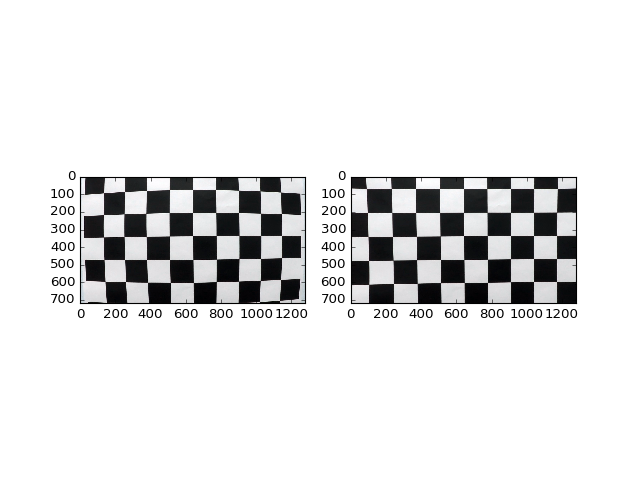

<IPython.core.display.Javascript object>


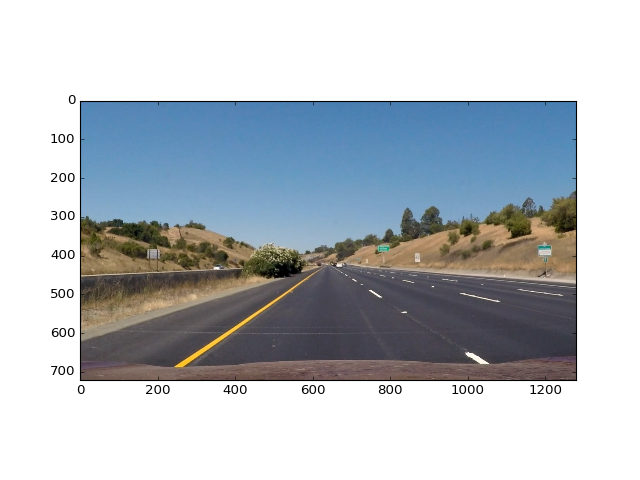

<IPython.core.display.Javascript object>


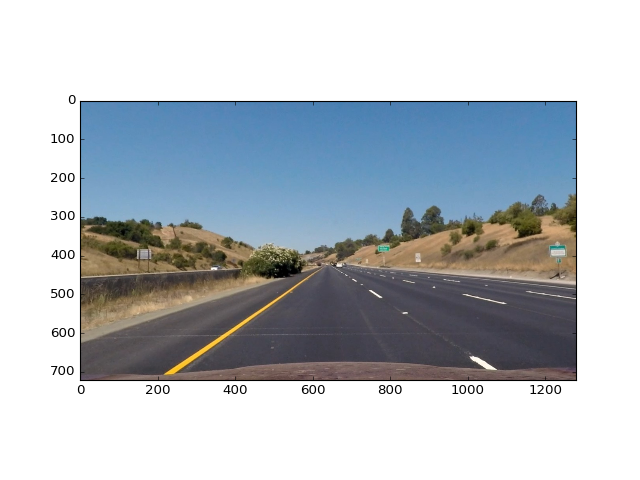

In [29]:
chess_shape = (9, 6)
objpoints = []
imgpoints = []
objp = np.zeros((6*9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1, 2)
for path in glob('camera_cal/*'):
    img = cv2.imread(path) 
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, chess_shape, None)
    
    if ret:
        imgpoints.append(corners)
        objpoints.append(objp)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

for path in islice(glob('camera_cal/*'), 1):
    img = cv2.imread(path)
    dst = undistort(img)
    show_images([img, dst])
    
for path in islice(glob('test_images/*'), 1):
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    dst = undistort(img)
    plt.figure()
    plt.imshow(img)
    plt.figure()
    plt.imshow(dst)
    plt.show()
    

### Perspective Transform

<IPython.core.display.Javascript object>


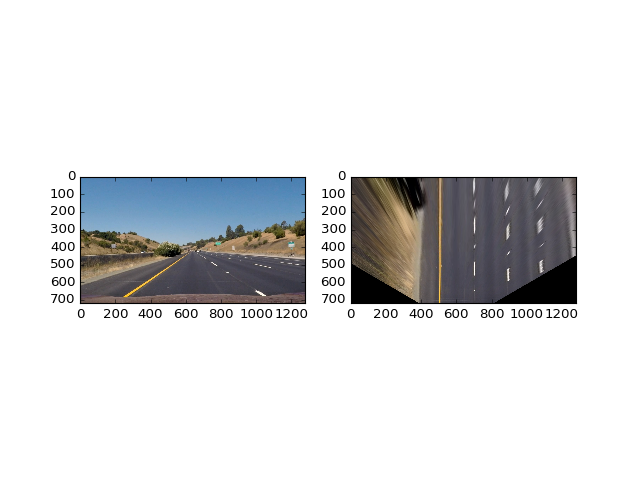

In [15]:
src = np.float32([
        [253, 685],
        [572, 465],
        [709, 465],
        [1052, 685]])

dst = np.float32([
        [500, 750],
        [500, 300],
        [700, 300],
        [700, 750]])

Mwarp = cv2.getPerspectiveTransform(src, dst)
Mrev = cv2.getPerspectiveTransform(dst, src)

def get_road(img):
    img_size = (img.shape[1], img.shape[0])
    # we mostly are interested in upscaling and CUBIC seems to be quite good
    # http://tanbakuchi.com/posts/comparison-of-openv-interpolation-algorithms/
    return cv2.warpPerspective(img, Mwarp, img_size, flags=cv2.INTER_CUBIC)
    
def unwarp(img):
    img_size = (img.shape[1], img.shape[0])
    return cv2.warpPerspective(img, Mrev, img_size)
    
for i in islice(glob('test_images3/*'), 1):
    img = np.asarray(Image.open(i))
    road = get_road(img)
    show_images([img, road])


test_images\straight_lines1.jpg


<IPython.core.display.Javascript object>


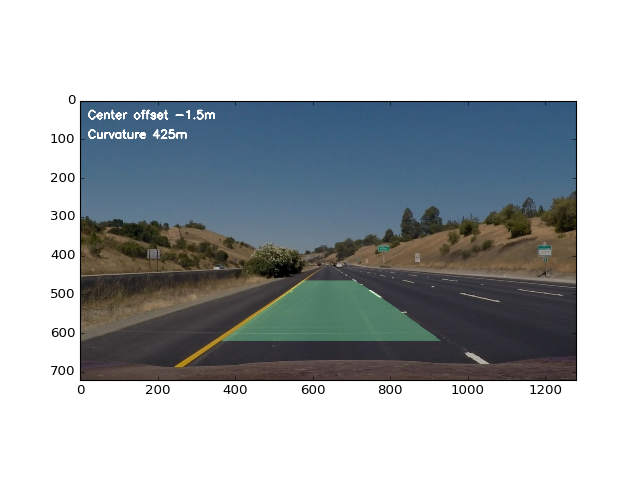

test_images\straight_lines2.jpg


<IPython.core.display.Javascript object>


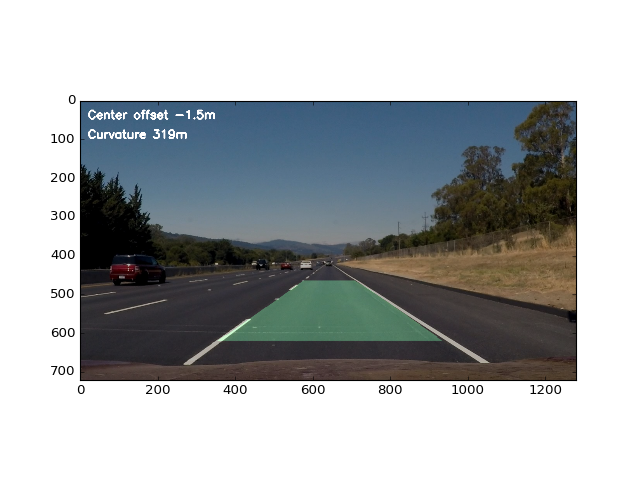

In [16]:
def norm(v):
    return np.sqrt(v.dot(v))


def show_with_lines(gray, lines):
    fig, ax = plt.subplots()

    for line in lines:
        f = line.poly2
        ys = np.array(range(0, gray.shape[0]))
        xs = np.int64(f(ys))
        ax.plot(xs, ys)

    marked = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
    ax.imshow(marked)
    plt.show()

        
class Line(object):
    def __init__(self, poly_coeffs):
        self.poly2 = np.poly1d(poly_coeffs)
        
    def __repr__(self):
        return "{}".format(self.poly2.coeffs)

        
    
def line_pair_quality(new, old):
    lc = new[0].poly2.coeffs
    rc = new[1].poly2.coeffs
    
    parallel = norm((rc - lc - np.array([0.0, 0.0, 180])) * [5000, 200, 1])
    
    bs = [np.poly1d(c)(720) for c in [lc, rc]]
    bottom_center = abs(bs[0] - 513) + abs(bs[1] - 693)
    
    return parallel + bottom_center * 2


def get_line(pixels):
    residuals, rank, singular_values, rcond, pre = np.polyfit(pixels[0], pixels[1], 2, full=True)
    return Line(residuals)
        

def find_best_line_pair(lines, old_lines):
    best_pair = [0, 1]
    best_pair_quality = line_pair_quality(lines[0:2], old_lines)
    
    count = len(lines)
    
    for l in range(len(lines)):
        for r in range(len(lines)):
            if l == r:
                continue
            q = line_pair_quality([lines[l], lines[r]], old_lines)
            if q < best_pair_quality:
                best_pair = [l, r]
                best_pair_quality = q
                
    return best_pair


def find_bright_lanes(img, old_lines):
    g_min = np.min(img)
    g_max = np.max(img)
    
    gray = (img - g_min) / (g_max - g_min)
    
    #show_images([gray])

    line_width = 8
    kernel = np.concatenate((np.repeat(-1, line_width / 2), 
                             np.repeat( 1, line_width), 
                             np.repeat(-1, line_width / 2)))

    kernel = kernel / np.sum(np.abs(kernel))
    kernel = kernel.reshape(1, -1)
    
    conv = cv2.filter2D(gray, -1, kernel)
    #show_images([conv])
    c_max = np.max(conv)
    
    conv[conv < 0.05] = 0
    #show_images([conv])
    
    
    def extract_lines(labels, object_count):
        #print("Number of objects: {}".format(object_count))
        
        lines = []

        for label in range(1, object_count + 1):
            pixels = np.where(labels == label)
            if len(pixels[0]) > 50:
                for p in zip(*pixels):
                    if p[0] > 300 and p[1] > 350 and p[1] < 850:
                        lines.append(get_line(pixels))
                        break
            
        return lines
    
    labels, object_count = measurements.label(conv)    

    lines = extract_lines(labels, object_count)
    #show_with_lines(np.uint8(gray * 255), lines)
    
    #for l in lines:
    #    print(l)
    
    best_pair = find_best_line_pair(lines, old_lines)
    return [lines[i] for i in best_pair]
    

def find_lanes(img, old_lines):
    #show_images([img])
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h = hsv[:, :, 0]
    s = hsv[:, :, 1]
    v = hsv[:, :, 2]
    yellow = cv2.inRange(h, 20, 23) #
    #print("yellow:")
    #show_images([yellow])
    lane_colors = np.maximum(gray, yellow)
    new_lines = find_bright_lanes(lane_colors, old_lines)
    
    if old_lines is not None:
        #print("Avg with old")
        lines = [Line(o.poly2.coeffs * 0.9 + n.poly2.coeffs * 0.1) for o, n in zip(old_lines, new_lines)]
    else:
        #print("New only")
        lines = new_lines
    
    #print(lines)
    lane_direction = np.average([l.poly2.coeffs for l in lines], axis=0)
    #print(lane_direction)
    
    car_offset = np.poly1d(lane_direction)(img.shape[0]) - img.shape[1]/2
    curvature = (((1 + (2*lane_direction[0]*img.shape[0] + lane_direction[1])**2)**1.5) 
                 / np.absolute(2*lane_direction[0]))

    meters_to_pixels_ratio = 3.0 / 80.0
    # 80 pixels ~= 3m
    car_offset_m = car_offset * meters_to_pixels_ratio
    curvature_m = curvature * meters_to_pixels_ratio

    #show_with_lines(gray, lines)
    
    return lines, car_offset_m, curvature_m
    
    
def process_image(img, lines):
    road = get_road(img)
    lines, car_offset_m, curvature_m = find_lanes(road, lines)
    markings = np.zeros_like(road)
    ys = range(300, 1200, 50)
    line_points = []
    step = 1
    for l in lines:
        line_points.extend([[np.int32(l.poly2(y)), y] for y in ys[::step]])
        step = -step
        
    cv2.fillConvexPoly(markings, np.asarray(line_points), [100, 255, 155])
        
    markings = unwarp(markings)
        
    img = np.uint8(img * 0.7 + markings * 0.3)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img, "Center offset {:.1f}m".format(car_offset_m), (20, 50), font, 1, (255, 255, 255), 3)
    cv2.putText(img, "Curvature {:.0f}m".format(curvature_m), (20, 100), font, 1, (255, 255, 255), 3)
    
    return img, lines


lines = None
fff = glob('test_images/*')
for i in islice(fff, 2):
    print(i)
    img = np.array(Image.open(i))
    #show_images([img])
    img, lines = process_image(img, lines)
    show_images([img])
    
  

### Some best pair tests from real examples

In [17]:
def test():
    lines = [Line(c) for c in [
        [ -2.82383990e-04,   3.18864517e-01,  4.27650275e+02],
        [ -1.06770783e-03,   4.33154179e-01,  7.34093445e+02],
        [  3.80097676e-04,  -1.02657154e-01,  6.35585156e+02],
        [  2.17074438e-03,  -1.83652077e+00,  1.16180932e+03],
        [ -1.69136327e-03,   1.23948238e+00,  4.30885056e+02],
        [  1.32287729e-02,  -1.06504087e+01,  2.94914156e+03],
        [ -3.10076257e-03,   2.69704321e+00,  2.26507834e+02],
        [  4.50821855e-04,  -2.98790970e-01,  7.11242035e+02],
        [  1.91154587e-04,  -8.79612952e-01,  1.22248405e+03],
        [ -6.00169380e-04,   6.52602631e-01,  2.26279793e+02],
        [ -1.36159644e-02,   1.45979370e+01, -3.22697654e+03],
        [  1.72019171e-03,  -1.75312771e+00,  1.29682681e+03],
        [ -3.01241707e-04,   4.85140331e-01,  5.06949001e+02]
    ]]

    best = find_best_line_pair(lines, None)
    if best != [0, 12]:
        print("fail, got {}".format(best))
    else:
        print("success")
        
def test2():
    lines = [Line(c) for c in [
        [  4.49682492e-04, -2.90692639e-01,  7.26908599e+02],
        [ -2.57546450e-02,  2.11077542e+01, -3.86431983e+03],
        [  4.34706522e-04, -3.44461130e-01,  7.57173728e+02],
        [ -6.39274890e-03,  5.74102519e+00, -4.42535360e+02],
        [  2.84357648e-06, -1.72789235e+00,  2.04781347e+03],
        [ -9.03770994e-03,  8.44264197e+00, -1.42709499e+03],
        [  3.62582346e-02, -3.48894959e+01,  8.89290365e+03],
        [  8.64567803e-04, -1.01309683e+00,  7.37349944e+02],
        [  4.10125169e-03, -4.20053671e+00,  1.59860914e+03],
        [ -2.80035214e-03,  2.83110736e+00, -2.84292053e+02],
        [  3.61434505e-04, -5.17461871e-01,  6.15215284e+02],
        [ -8.47950315e-04,  8.62619149e-01,  2.08541817e+02],
        [  1.07559110e-02, -1.19750597e+01,  3.85393763e+03],
        [ -1.28520029e-02,  1.50835191e+01, -3.90431267e+03],
        [  7.00373541e-04, -9.50962207e-01,  7.39840286e+02],
        [ -6.27214314e-04,  8.13116974e-01,  4.34268241e+02],
        [  2.04562000e-04, -3.63975253e-01,  5.79178412e+02],
        [ -1.10993494e-04,  9.56479120e-02,  5.00226958e+02],
        [  1.95917746e-03, -2.57458852e+00,  1.26206914e+03],
        [ -8.43069537e-04,  1.07946474e+00,  6.89314944e+01],
        [ -1.60222050e-03,  2.18597502e+00, -3.34092570e+02]
    ]]
    best = find_best_line_pair(lines, None)
    if best not in [[17, 0], [17, 2]]:
        print("fail, got {}".format(best))
    else:
        print("success")
        
test()
test2()

success
success


<IPython.core.display.Javascript object>


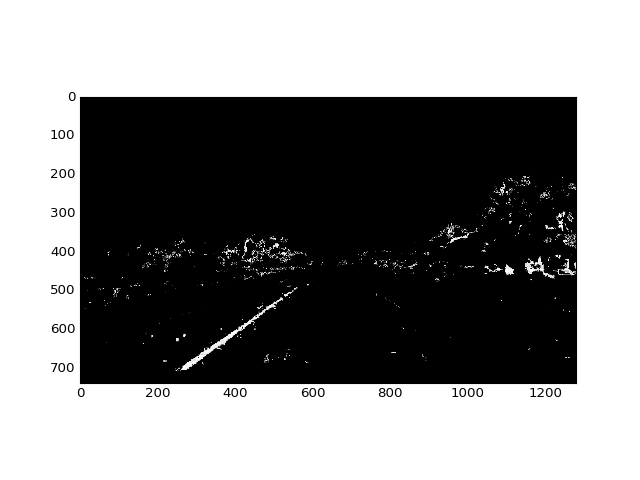

In [18]:
# Experiment with yellow cutoffs

img = np.array(Image.open('test_images_tough/vlcsnap-2017-03-08-11h30m23s997.png'))
    
@interact(img = fixed(img), lh = IntSlider(min=0, max=40, value=20, width='800px'), hh = IntSlider(min=0, max=40, value=23, width='800px'))
def show_hue(img, lh, hh):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h = hsv[:, :, 0]
    h[(h < lh) | (h > hh)] = 0
    plt.figure()
    plt.imshow(h, cmap = 'gray')
    plt.show() 


In [19]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_video(file_name):
    process_video.lines2 = None
    def process_frame(image):
        try:
            result, process_video.lines2 = process_image(image, process_video.lines2)
        except Exception as ex:
            print("failed {}".format(ex))
            show_images([image])
            result = image

        return result

    clip = VideoFileClip(file_name)
    processed_clip = clip.fl_image(process_frame)
    %time processed_clip.write_videofile(file_name.replace('.', '-output.'), audio=False)
    
#process_video("vlc-record-2017-03-09-23h20m18s-project_video.mp4")
process_video("project_video.mp4")

[MoviePy] >>>> Building video project_video-output.mp4
[MoviePy] Writing video project_video-output.mp4


100%|█████████████████████████████████████▉| 1260/1261 [29:21<00:01,  1.47s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video-output.mp4 

Wall time: 29min 22s
